In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# dataset
df = pd.read_csv('/content/ped_exposure_data_sample.csv')

# dataset overview
print("Dataset Overview:")
print(df.info())
print(df.describe())

# Predictor variables
independent_vars = ['PopT', 'WalkComT', 'HseHldT', 'PrincArt', 'MinorArt', 'Collector', 'Int4way', 'SchoolsT',
                    'Signal', 'MaxSlope', 'EmpSF_T', 'EmpT', 'StMetersT', 'StSegT']

# Dependent variables
y_linear = df['AnnualEst']  # Original scale
y_log = df['logAnnualEst']  # Log-transformed

# 1. Split data into training (80%) and testing (20%)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Preparing training and testing sets
X_train = sm.add_constant(train_data[independent_vars])
X_test = sm.add_constant(test_data[independent_vars])
y_train_linear = train_data['AnnualEst']
y_test_linear = test_data['AnnualEst']
y_train_log = train_data['logAnnualEst']
y_test_log = test_data['logAnnualEst']

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Intersection  1274 non-null   object 
 1   Latitude      1274 non-null   float64
 2   Longitude     1274 non-null   float64
 3   District      1274 non-null   int64  
 4   County        1274 non-null   object 
 5   AnnualEst     1274 non-null   int64  
 6   logAnnualEst  1274 non-null   float64
 7   PopT          1274 non-null   float64
 8   WalkComT      1274 non-null   float64
 9   HseHldT       1274 non-null   float64
 10  PrincArt      1274 non-null   int64  
 11  MinorArt      1274 non-null   int64  
 12  Collector     1274 non-null   int64  
 13  Int4way       1274 non-null   int64  
 14  SchoolsT      1274 non-null   int64  
 15  Signal        1274 non-null   int64  
 16  MaxSlope      1274 non-null   float64
 17  EmpSF_T       1274 non-null   float64
 18  EmpT      

In [17]:
# 2. Fiting Linear and Log-Linear Regression Models
model_linear = sm.OLS(y_train_linear, X_train).fit()
model_log = sm.OLS(y_train_log, X_train).fit()

# Model summaries
print("Linear Model Summary:")
print(model_linear.summary())

print("Log-Linear Model Summary:")
print(model_log.summary())

Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:              AnnualEst   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     103.0
Date:                Tue, 25 Mar 2025   Prob (F-statistic):          7.17e-183
Time:                        16:43:46   Log-Likelihood:                -16073.
No. Observations:                1019   AIC:                         3.218e+04
Df Residuals:                    1004   BIC:                         3.225e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.727e+05   2.39e+

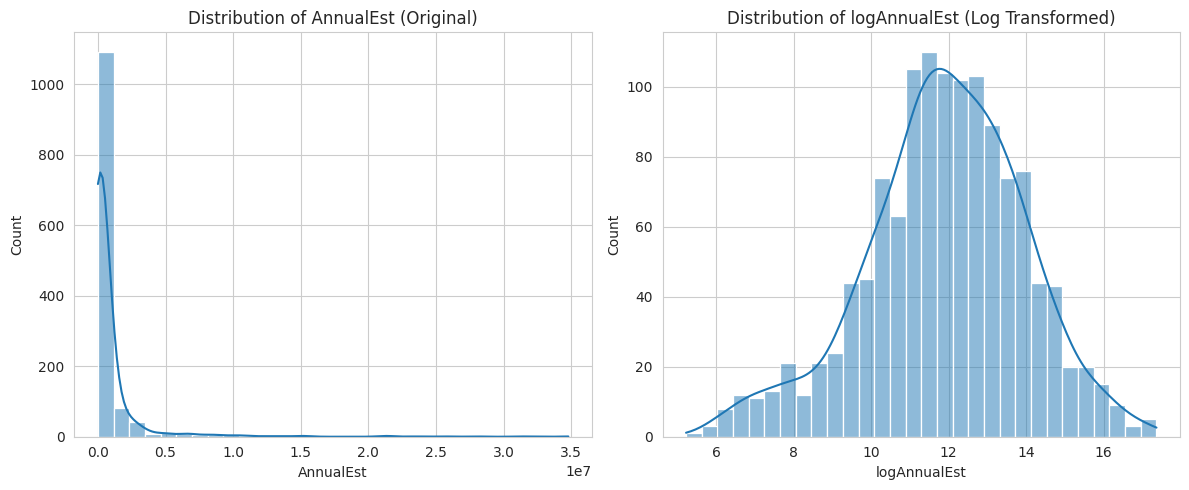

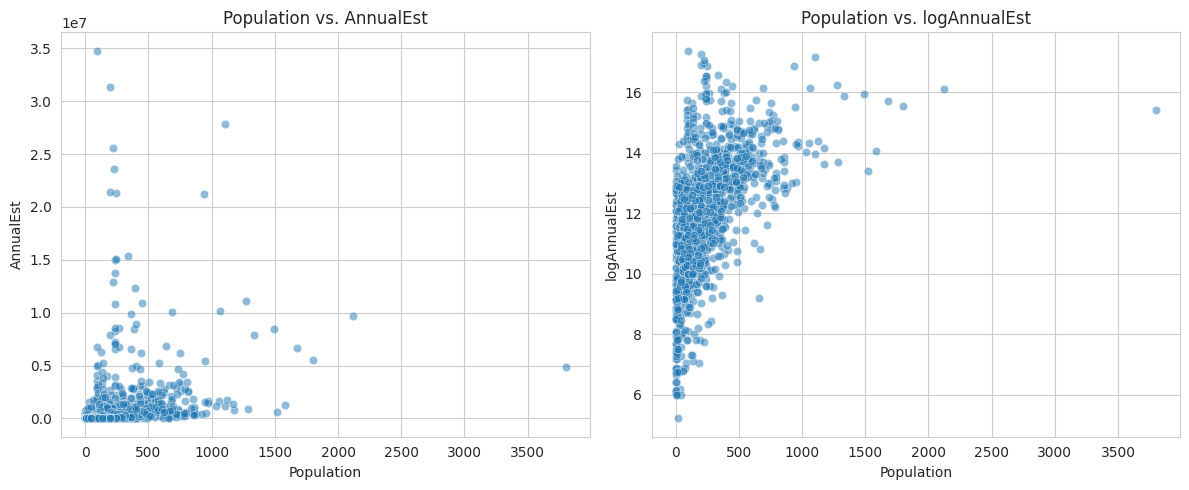

In [18]:
# for plots
sns.set_style("whitegrid")

# Distribution of AnnualEst and logAnnualEst
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["AnnualEst"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of AnnualEst (Original)")
axes[0].set_xlabel("AnnualEst")

sns.histplot(df["logAnnualEst"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of logAnnualEst (Log Transformed)")
axes[1].set_xlabel("logAnnualEst")

plt.tight_layout()
plt.show()

# Scatter plot of Population vs. AnnualEst & logAnnualEst
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=df["PopT"], y=df["AnnualEst"], alpha=0.5, ax=axes[0])
axes[0].set_title("Population vs. AnnualEst")
axes[0].set_xlabel("Population")
axes[0].set_ylabel("AnnualEst")

sns.scatterplot(x=df["PopT"], y=df["logAnnualEst"], alpha=0.5, ax=axes[1])
axes[1].set_title("Population vs. logAnnualEst")
axes[1].set_xlabel("Population")
axes[1].set_ylabel("logAnnualEst")

plt.tight_layout()
plt.show()

In [19]:
# 3. Computation of Root Mean Squared Error (RMSE)
def compute_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Predict using both models
predictions_linear = model_linear.predict(X_test)
predictions_log = np.exp(model_log.predict(X_test))  # Converting log-estimates back to original scale

# Compute RMSE for both models
rmse_linear = compute_rmse(y_test_linear, predictions_linear)
rmse_log = compute_rmse(y_test_linear, predictions_log)

print(f"RMSE for Linear Model: {rmse_linear}")
print(f"RMSE for Log-Linear Model: {rmse_log}")

RMSE for Linear Model: 1775608.5987438625
RMSE for Log-Linear Model: 5119383.3362149205


In [20]:
# 4. Summarizing pedestrian volumes by district
district_summary = df.groupby('District')['AnnualEst'].describe()

# Computing confidence intervals for each district
def compute_ci(data):
    mean = data.mean()
    std = data.std()
    n = len(data)
    ci = stats.t.interval(0.95, n-1, loc=mean, scale=std/np.sqrt(n))
    return ci

district_summary['CI'] = df.groupby('District')['AnnualEst'].apply(compute_ci)
print(district_summary)

          count          mean           std      min        25%       50%  \
District                                                                    
1          83.0  1.459434e+05  1.443526e+05    427.0   15412.50  103799.0   
2          18.0  1.127884e+05  9.557125e+04  17962.0   49310.75   87675.0   
3          96.0  9.298572e+04  1.087133e+05    444.0   21501.75   57766.5   
4         157.0  2.798850e+06  6.214247e+06   9996.0  193824.00  450190.0   
5         174.0  3.084595e+05  7.363829e+05    397.0   16067.75   79601.5   
6          58.0  4.283067e+04  4.729752e+04   2426.0   14512.00   27857.5   
7         419.0  1.188169e+06  1.977618e+06    403.0  139389.50  487761.0   
8          32.0  6.456909e+04  1.019936e+05    942.0   10136.00   25175.0   
9          26.0  1.229700e+05  2.144667e+05   2891.0    7114.75   39141.5   
10         46.0  8.753135e+04  1.390337e+05    185.0    9227.50   50729.0   
12        165.0  4.293181e+05  6.075249e+05   1149.0   60919.00  147126.0   

In [21]:
# 5. Two-sample t-test (District 4 vs District 7)
district_4 = df[df['District'] == 4]['AnnualEst']
district_7 = df[df['District'] == 7]['AnnualEst']
t_stat, p_value = stats.ttest_ind(district_4, district_7)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 4.71220833449997, P-value: 3.0780656815871714e-06


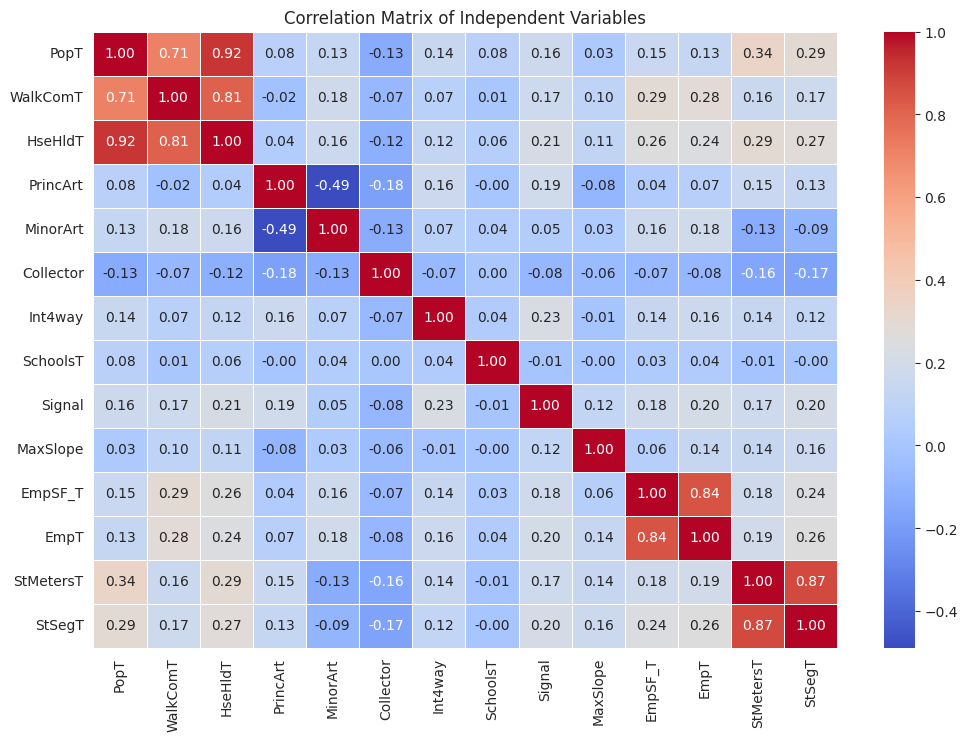

In [22]:
# 6. Correlation Analysis
corr_matrix = df[independent_vars].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Independent Variables')
plt.show()

In [23]:
# 7. Final Model Selection
if rmse_log < rmse_linear:
    print("Log-Linear Model is preferred due to lower RMSE and better R-squared.")
else:
    print("Linear Model is preferred due to lower RMSE.")

Linear Model is preferred due to lower RMSE.
